# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement neural networks in Homework 1, we just prepare the implementation for you.

In [2]:
# import necessary dependencies
import argparse
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def swish(x):
    return x/(1+torch.exp(-x))

In [4]:
# define the Resnet20 mode;
class Resnet20(nn.Module):
    def __init__(self):
        super(Resnet20, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm0 = nn.BatchNorm2d(16)
        
        self.conv1a = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1a = nn.BatchNorm2d(16)
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1b = nn.BatchNorm2d(16)
        self.conv1c = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1c = nn.BatchNorm2d(16)
        self.conv1d = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1d = nn.BatchNorm2d(16)
        self.conv1e = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1e = nn.BatchNorm2d(16)
        self.conv1f = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1f = nn.BatchNorm2d(16)
        
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.batchnorm1_2 = nn.BatchNorm2d(32)
        self.bypass1_2 = nn.Conv2d(16, 32, 1, stride=2)
        self.conv2a = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2b = nn.BatchNorm2d(32)
        self.conv2c = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2c = nn.BatchNorm2d(32)
        self.conv2d = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(32)
        self.conv2e = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2e = nn.BatchNorm2d(32)
        
        self.conv2_3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchnorm2_3 = nn.BatchNorm2d(64)
        self.bypass2_3 = nn.Conv2d(32, 64, 1, stride=2)
        self.conv3a = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3a = nn.BatchNorm2d(64)
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3b = nn.BatchNorm2d(64)
        self.conv3c = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3c = nn.BatchNorm2d(64)
        self.conv3d = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3d = nn.BatchNorm2d(64)
        self.conv3e = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3e = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # Inital convolution
        out = self.batchnorm0(self.conv0(x))
        out = bypass = swish(out)
        # Block 1   (condense block layers into functions)
            # Layer 1
        out = self.batchnorm1a(self.conv1a(out))
        out = swish(out)
        out = self.batchnorm1b(self.conv1b(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm1c(self.conv1c(out))
        out = swish(out)
        out = self.batchnorm1d(self.conv1d(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm1e(self.conv1e(out))
        out = swish(out)
        out = self.batchnorm1f(self.conv1f(out))
        out = bypass = swish(out + bypass)
        # Block 2
            # Layer 1
        bypass = self.bypass1_2(bypass)
        out = self.batchnorm1_2(self.conv1_2(out))
        out = swish(out)
        out = self.batchnorm2a(self.conv2a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm2b(self.conv2b(out))
        out = swish(out)
        out = self.batchnorm2c(self.conv2c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm2d(self.conv2d(out))
        out = swish(out)
        out = self.batchnorm2e(self.conv2e(out))
        out = bypass = swish(out + bypass)
        # Block 3
            # Layer 1
        bypass = self.bypass2_3(bypass)
        out = self.batchnorm2_3(self.conv2_3(out))
        out = swish(out)
        out = self.batchnorm3a(self.conv3a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm3b(self.conv3b(out))
        out = swish(out)
        out = self.batchnorm3c(self.conv3c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm3d(self.conv3d(out))
        out = swish(out)
        out = self.batchnorm3e(self.conv3e(out))
        out = bypass = swish(out + bypass)
        
        # Global Average Pool to go from 8x8 -> 1x1 feature maps
        out = F.avg_pool2d(out, 8)
        
        # Fully Connected Layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [10]:
# specify the device for computation
#############################################
# your code here

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
net = Resnet20()
net = net.to(device)
if device == 'cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")
    
#############################################

Train on CPU...


In [1]:
import torch
if torch.cuda.is_available():
  print("yes")

yes


In [6]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tools.dataset import CIFAR10
import torch.nn.functional as F


In [39]:
def softmax(val, T =1000):
  x = val.cpu().detach()
  out = torch.zeros(x.size())

  for i in range(len(out)):
    sum = 0
    for j in range(len(out[0])):
      out[i][j] = np.exp(x[i][j]/T)
      sum+= out[i][j]
    out[i] = out[i]/sum
  return out

In [7]:
import torchvision
import torchvision.transforms as transforms
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [14]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
DATA_ROOT = "./data"
OOD_Data = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_val,
    download=True
)
ID_Data = CIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_val,
    download=True
)

ID_loader = DataLoader(
    ID_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)
OOD_loader = DataLoader(
    OOD_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
net = Resnet20()
chkpnt = torch.load('./resnet20.pth',map_location ='cpu')['state_dict']
net.load_state_dict(chkpnt)
#chkpnt = torch.load('./resnet_new.h5')
#net.load_state_dict(chkpnt['net'])


net.cuda()
net.eval()
softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(ID_loader):
        inputs = inputs.to(device)
        y = net(inputs.cuda())
        softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
softmaxes = torch.cat(softmaxes)
total_examples = indexes.size()[0]


    

In [50]:
def plot_true_pos(vals):
  TPRs = []
  opt = .95
  opt_x = 0
  opt_y = 0
  dist = 1000
  x_range = np.linspace(0.05, .15, 1000)
  for i in x_range:
    TPR = sum(vals > i)/len(vals)
    TPRs.append(TPR)
    if(np.abs(opt-TPR)<=dist):
      opt_x, opt_y, dist= i, TPR, (np.abs(opt-TPR))
  plt.plot( x_range,TPRs, 'm')
  plt.plot(opt_x, opt_y, 'X', ms=11, label="Threshold at 95%")
  plt.xlabel("Threshold")
  plt.ylabel("True Positive Rate")
  plt.title("In-Distribution Threshold for TPR")
  plt.legend()
  plt.show()
  print(f"Threshold at 95% = {opt_x}")

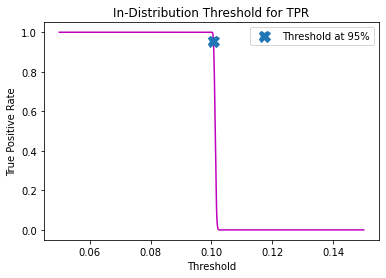

Threshold at 95% = 0.10065065065065065


In [51]:
plot_true_pos(softmaxes)

In [114]:
def plot_roc(ID_vals, OOD_vals, title):
  TPRs = []     #  true positive rates
  FPRs = []     # false positive rates
  AUROC = []    # will contain the AUROC approximation segments
  opt = .95
  opt2=.05
  opt1_TPR = 0
  opt1_FPR = 0
  distTPR = 1000
  opt2_TPR = 0
  opt2_FPR = 0
  distFPR = 1000
  prev_FPR = 0
  for i in np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000):
      TPR = sum(OOD_vals < i)/len(OOD_vals)
      FPR = sum(ID_vals < i)/len(ID_vals)
      TPRs.append(TPR)
      FPRs.append(FPR)
      AUROC.append((FPR-prev_FPR)*TPR)
      prev_FPR = FPR 
      if(np.abs(opt-TPR)<distTPR):
        opt1_TPR, opt1_FPR, distTPR= TPR, FPR, (np.abs(opt-TPR))
      if(np.abs(opt2-FPR)<distFPR):
        opt2_TPR, opt2_FPR, distFPR= TPR, FPR, (np.abs(opt2-FPR))
  plt.plot(FPRs, TPRs, 'm')
  plt.plot([0,1], [0,1], "k--", linewidth=.5)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  plt.plot(opt1_FPR, opt1_TPR, 'X', ms=11, label=f"95% TPR")
  plt.plot(opt2_FPR, opt2_TPR, 'X', ms=11, label=f"5% FPR")
  plt.legend()
  plt.show()
  print(f"FPR at 95%TPR = {opt1_FPR}")
  print(f"TNR at 95%TPR = {1-opt1_FPR}")
  print(f"TPR at 5%FPR = {opt2_TPR}")
  print(f"AUROC: {sum(AUROC)}")

In [125]:

OOD_softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(OOD_loader):
        inputs = inputs.to(device)
        y = net(inputs.cuda())
        OOD_softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
OOD_softmaxes = torch.cat(OOD_softmaxes)
total_examples = indexes.size()[0]


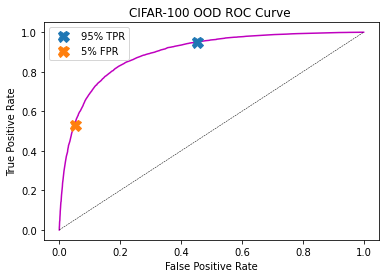

FPR at 95%TPR = 0.45329999923706055
TNR at 95%TPR = 0.5467000007629395
TPR at 5%FPR = 0.5325999855995178
AUROC: 0.8931652903556824


In [126]:
plot_roc(softmaxes, OOD_softmaxes, "CIFAR-100 OOD ROC Curve ")

In [36]:
from torchvision.datasets import SVHN

SVHN_OOD_Data = SVHN(
    root=DATA_ROOT,
    split="test",
    transform=transform_val,
    download=True
)
SVHN_OOD_loader = DataLoader(
    SVHN_OOD_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [127]:

SVHN_OOD_softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(SVHN_OOD_loader):
        inputs = inputs.to(device)
        y = net(inputs.cuda())
        SVHN_OOD_softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
SVHN_OOD_softmaxes = torch.cat(SVHN_OOD_softmaxes)
total_examples = indexes.size()[0]

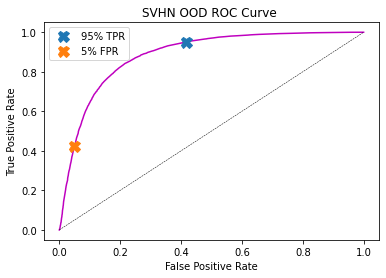

FPR at 95%TPR = 0.4156000018119812
TNR at 95%TPR = 0.5843999981880188
TPR at 5%FPR = 0.4224031865596771
AUROC: 0.8850575089454651


In [128]:
plot_roc(softmaxes, SVHN_OOD_softmaxes, "SVHN OOD ROC Curve ")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
from torchvision.datasets import MNIST
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda inputs1: inputs1.repeat(3, 1, 1) ),
    transforms.RandomCrop(32, padding=2),
    transforms.Normalize((0.4914), (0.2023)),
    
])
MNIST_OOD_Data = MNIST(
    root=DATA_ROOT,
    train=False,
    transform=transform_MNIST,
    download = True

)
MNIST_OOD_loader = DataLoader(
    MNIST_OOD_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)

In [129]:
import tensorflow as tf
MNIST_OOD_softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs1, targets1) in enumerate(MNIST_OOD_loader):
        x = inputs1
        inputs1 = x
        inputs1 = inputs1.to(device)
        y = net(inputs1.cuda())
        MNIST_OOD_softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
MNIST_OOD_softmaxes = torch.cat(MNIST_OOD_softmaxes)
total_examples = indexes.size()[0]

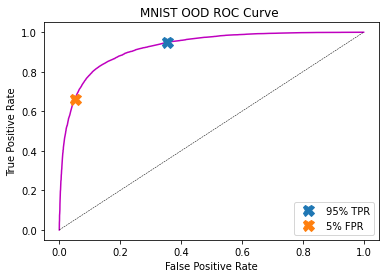

FPR at 95%TPR = 0.35530000925064087
TNR at 95%TPR = 0.6446999907493591
TPR at 5%FPR = 0.6607000231742859
AUROC: 0.9242808818817139


In [130]:
plot_roc(softmaxes, MNIST_OOD_softmaxes, "MNIST OOD ROC Curve ")

In [115]:
pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
import tensorflow_datasets as tfds
ds = tfds.load('lsun', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: ignored

In [120]:

transform_LSUN = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda inputs1: inputs1.repeat(3, 1, 1) ),
    transforms.RandomCrop(32, padding=2),
    transforms.Normalize((0.4914), (0.2023)),
    
])

scriptdir = os.path.dirname(__file__)


LSUN_OOD_Data = LSUN(
    root=DATA_ROOT,
    classes='test',
    transform=transform_LSUN,

)
LSUN_OOD_loader = DataLoader(
    MNIST_OOD_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)

Error: ignored